In [457]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Import Raw Data Example

In [458]:
ex_coords_file = "I:/documents/DLCPaper/revisions/data/kinematic/example_data/07202023PANB0605DLC_rawangles.csv"
ex_peaks_file = "I:/documents/DLCPaper/revisions/data/kinematic/example_data/07202023PANB0605DLC_peaks.csv"
ex_cycles_file = "I:/documents/DLCPaper/revisions/data/kinematic/example_data/07202023PANB0605DLC_cycles.csv"

# example raw coordinates
ex_coords = pd.read_csv(ex_coords_file)

# example peaks detected
ex_peaks = pd.read_csv(ex_peaks_file)

# example cycles
ex_cycles = pd.read_csv(ex_cycles_file)

# Import Cycle Data

In [459]:
cycle_folder_path = "I:/documents/DLCPaper/revisions/data/kinematic/cycles/all-nddc" 
cycle_folder_path_relative = "I:/documents/DLCPaper/revisions/data/kinematic/cycles/all-smoothednddc"

# instantaneous nd-dc flexion
cycles_dfs = [pd.read_csv(os.path.join(cycle_folder_path, f)) for f in os.listdir(cycle_folder_path) if f.startswith('cycles_') and f.endswith('.csv') and not pd.read_csv(os.path.join(cycle_folder_path, f)).empty]
cycles = pd.concat(cycles_dfs, ignore_index=True)

# relative nd(smoothed)-dc flexion
cycles_dfs_relative = [pd.read_csv(os.path.join(cycle_folder_path_relative, f)) for f in os.listdir(cycle_folder_path_relative) if f.startswith('cycles_') and f.endswith('.csv') and not pd.read_csv(os.path.join(cycle_folder_path_relative, f)).empty]
cycles_relative = pd.concat(cycles_dfs_relative, ignore_index=True)

Clean & Summarize Cycles Data

In [460]:
# make cleaned df with bounded TBF for relative operations, TBF=[0.3,0.5]
clean_cycles = cycles[(cycles['frequency_hz'] > 0.3) & (cycles['frequency_hz'] < 0.5)] # filter when doing relative operations

# make cleaned df with bounded TBF for relative operations, TBF=[0.3,0.5]
clean_cycles_relative = cycles_relative[(cycles_relative['frequency_hz'] > 0.3) & (cycles_relative['frequency_hz'] < 0.5)] # filter when doing relative operations

# summarize instantaneous nd-dc
cycles_sum = cycles.groupby('filename').agg(
    frequency_hz=('frequency_hz', 'mean'), flex_amplitude_BL=('flex_amplitude_BL', 'mean'),
    head_amplitude_BL=('head_amplitude_BL', 'mean'), n=('frequency_hz', 'size')).reset_index()

# summarize cleaned instantaneous nd-dc
clean_cycles_sum = clean_cycles.groupby('filename').agg(
    frequency_hz=('frequency_hz', 'mean'), flex_amplitude_BL=('flex_amplitude_BL', 'mean'),
    head_amplitude_BL=('head_amplitude_BL', 'mean'), n=('frequency_hz', 'size')).reset_index()

# summarize cleaned relative nd(smoothed)-dc
clean_cycles_relative_sum = clean_cycles_relative.groupby('filename').agg(
    frequency_hz=('frequency_hz', 'mean'), flex_amplitude_BL=('flex_amplitude_BL', 'mean'),
    head_amplitude_BL=('head_amplitude_BL', 'mean'), n=('frequency_hz', 'size')).reset_index()


# Plot Raw Data Example 

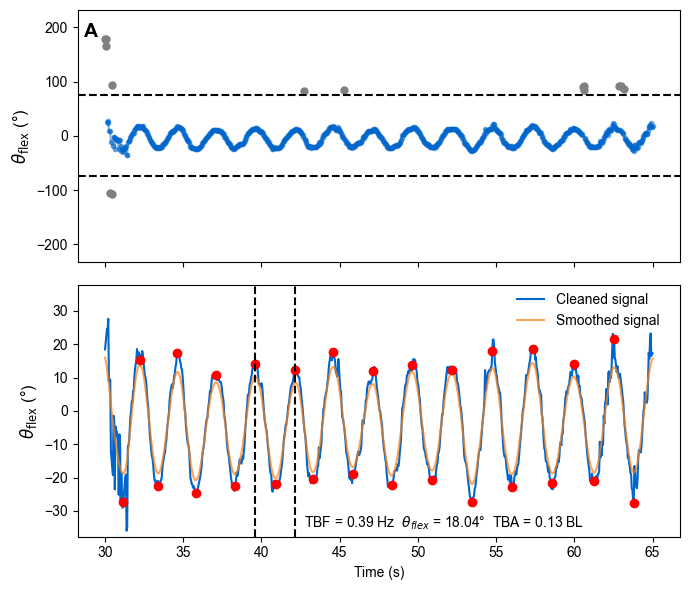

In [477]:
plt.rcParams['font.family'] = 'Arial'

# Convert 'index' to time in seconds
ex_coords['time_s'] = ex_coords['index'] / 24
ex_peaks['time_s'] = ex_peaks['index'] / 24
ex_peaks['smooth_signal_deg'] = ex_peaks['smooth_signal'] * (180 / np.pi)

# Trim data to 30–65 seconds for plotting, but don't limit x-axis range
coords_trimmed = ex_coords[(ex_coords['time_s'] >= 30) & (ex_coords['time_s'] <= 65)]
peaks_trimmed = ex_peaks[(ex_peaks['time_s'] >= 30) & (ex_peaks['time_s'] <= 65)]

# Calculate maximum absolute values for scaling
coords_ymax = abs(coords_trimmed['theta_flex_deg']).max()
peaks_ymax = abs(peaks_trimmed['theta_flex_deg']).max()

# Extend y-limits 
coords_ymax_extended = coords_ymax * 1.3
peaks_ymax_extended = peaks_ymax * 1.05

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(7, 6))

# Define the new blue color
blue_color = "#0066cc"  # Hex for blue
orange_color = "#ff7f0e"  # Hex for orange

# --- Top panel (A) with alpha, gray outliers, and sequential line ---
# Mask for gray points
is_extreme = (coords_trimmed['theta_flex_deg'] > 75) | (coords_trimmed['theta_flex_deg'] < -75)
not_extreme = ~is_extreme

# Gray points (extreme) - larger points
ax1.scatter(
    coords_trimmed.loc[is_extreme, 'time_s'],
    coords_trimmed.loc[is_extreme, 'theta_flex_deg'],
    color='gray', s=25  # Larger point size
)

# Connecting all points sequentially (non-extreme) with blue color
ax1.plot(
    coords_trimmed.loc[not_extreme, 'time_s'],
    coords_trimmed.loc[not_extreme, 'theta_flex_deg'],
    color=blue_color, alpha=0.5, marker='o', linestyle='-', markersize=3  # Smaller point size
)

# Horizontal dashed lines at 75 and -75
ax1.axhline(75, color='black', linestyle='--')
ax1.axhline(-75, color='black', linestyle='--')

# Set labels and y-limits
ax1.set_ylabel(r'$\theta_{\mathrm{flex}}$ (°)', fontsize=12)  # Greek letter and subscript
ax1.set_ylim(-coords_ymax_extended, coords_ymax_extended)
ax1.text(0.01, 0.95, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# --- Bottom panel (B) with line, peaks/minima, and smooth_signal ---
# Plot theta_flex_deg from ex_peaks in blue
ax2.plot(peaks_trimmed['time_s'], peaks_trimmed['theta_flex_deg'], color=blue_color, label='Cleaned signal')  # No fade (fully opaque)

# Plot smooth_signal_deg (converted) from ex_peaks in orange
ax2.plot(peaks_trimmed['time_s'], peaks_trimmed['smooth_signal_deg'], color=orange_color, linestyle='-', alpha=0.7, label='Smoothed signal')

# Red dots for peaks
ax2.plot(
    peaks_trimmed.loc[peaks_trimmed['peaks'] == 1, 'time_s'],
    peaks_trimmed.loc[peaks_trimmed['peaks'] == 1, 'theta_flex_deg'],
    'o', color='red'
)

# Red dots for minima
ax2.plot(
    peaks_trimmed.loc[peaks_trimmed['minima'] == 1, 'time_s'],
    peaks_trimmed.loc[peaks_trimmed['minima'] == 1, 'theta_flex_deg'],
    'o', color='red'
)

# Identify the time of the 4th and 5th peaks
peak_times = peaks_trimmed.loc[peaks_trimmed['peaks'] == 1, 'time_s'].values
if len(peak_times) >= 5:
    peak_4_time = peak_times[3]  # 4th peak (0-indexed)
    peak_5_time = peak_times[4]  # 5th peak (0-indexed)

    # Add vertical black dashed lines at the 4th and 5th peaks
    ax2.axvline(peak_4_time, color='black', linestyle='--')
    ax2.axvline(peak_5_time, color='black', linestyle='--')

# Pull values from the 4th cycle (index = 4) in ex_cycles
cycle_data = ex_cycles.iloc[4]  # 4th cycle (fifth row)
frequency_hz = cycle_data['frequency_hz']
flex_amplitude_deg = cycle_data['flex_amplitude_deg']
flex_amplitude_BL = cycle_data['flex_amplitude_BL']

# Add legend to the bottom plot with no border for the lines
ax2.legend(loc='upper right', borderpad=1, frameon=False, bbox_to_anchor=(1.0, 1.05))

# Set labels and y-limits for bottom plot
ax2.set_ylabel(r'$\theta_{\mathrm{flex}}$ (°)', fontsize=12)  # Greek letter and subscript
ax2.set_xlabel('Time (s)')
ax2.set_ylim(-peaks_ymax_extended, peaks_ymax_extended)

# Manually add the TBF, θ flex, and TBA text in the bottom-right corner (shifted down)
ax2.text(
    0.84, 0.02,  # Adjusted position for shifting down slightly
    f"TBF = {frequency_hz:.2f} Hz  "
    f"$\\theta_{{flex}}$ = {flex_amplitude_deg:.2f}°  "
    f"TBA = {flex_amplitude_BL:.2f} BL",
    transform=ax2.transAxes,
    fontsize=10,
    ha='right',
    va='bottom'
)

# Tidy layout
plt.tight_layout()

# Save the figure as a .jpg file
output_path = "I:/documents/DLCPaper/revisions/figures/Figure4.jpg"  # Specify the path and file name
fig.savefig(output_path, format='jpg', dpi=300)  # Save the figure with 300 dpi resolution

# Display the plot
plt.show()

In [439]:
ex_cycles

,frequency_hz,t_s,flex_amplitude_deg,head_amplitude_deg,flex_amplitude_BL,head_amplitude_BL,BL_pixels,segment_id
0,0.421053,29.833333,25.100260,11.182655,0.289934,0.074576,558.102965,0
1,0.413793,32.208333,18.918922,8.967987,0.116792,0.034239,408.638954,0
2,0.406780,34.625000,20.970383,8.755696,0.128110,0.030692,406.998744,0
3,0.400000,37.083333,16.595907,7.372336,0.123140,0.025565,403.683873,0
4,0.387097,39.583333,18.038411,7.774721,0.126367,0.026664,404.405091,0
5,0.413793,42.166667,16.340861,8.366499,0.196678,0.025824,405.452833,0
6,0.393443,44.583333,18.218531,8.503717,0.210981,0.027349,405.013245,0
7,0.400000,47.125000,17.120167,7.533005,0.123825,0.024193,410.620968,0
8,0.393443,49.625000,17.228037,7.730978,0.116638,0.023765,407.902768,0
9,0.387097,52.166667,19.775658,9.403794,0.147971,0.026905,408.659806,0


# Plot TB Frequency and Angle

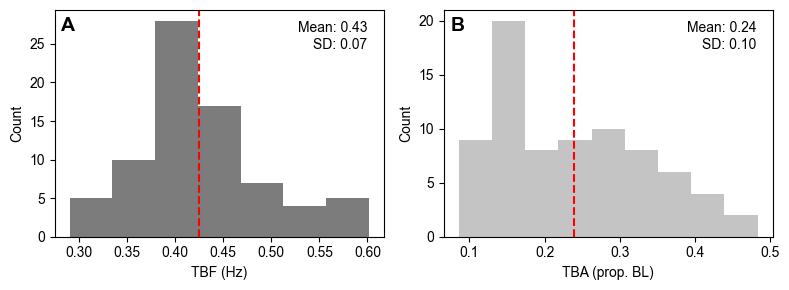

In [485]:
plt.rcParams['font.family'] = 'Arial'  # Set font to Arial
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Define colors
light_grey = "#B0B0B0"  # Light grey for flexion amplitude
dark_grey = "#505050"   # Dark grey for frequency

# frequency
sns.histplot(cycles_sum['frequency_hz'], kde=False, ax=axes[0], color=dark_grey, edgecolor=None, binwidth=0.045)

mean_freq = cycles_sum['frequency_hz'].mean()
std_freq = cycles_sum['frequency_hz'].std()
axes[0].axvline(mean_freq, color='red', linestyle='dashed')
axes[0].text(0.95, 0.95, f'Mean: {mean_freq:.2f}\nSD: {std_freq:.2f}', 
             transform=axes[0].transAxes, ha='right', va='top', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
axes[0].set_xlabel('TBF (Hz)')
axes[0].text(0.02, 0.97, 'A', transform=axes[0].transAxes,
             fontsize=14, fontweight='bold', ha='left', va='top')

# flexion amplitude
sns.histplot(cycles_sum['flex_amplitude_BL'], kde=False, ax=axes[1], color=light_grey, edgecolor=None, binwidth=0.045)

mean_flex = cycles_sum['flex_amplitude_BL'].mean()
std_flex = cycles_sum['flex_amplitude_BL'].std()
axes[1].axvline(mean_flex, color='red', linestyle='dashed')
axes[1].text(0.95, 0.95, f'Mean: {mean_flex:.2f}\nSD: {std_flex:.2f}', 
             transform=axes[1].transAxes, ha='right', va='top', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
axes[1].set_xlabel('TBA (prop. BL)')
axes[1].text(0.02, 0.97, 'B', transform=axes[1].transAxes,
             fontsize=14, fontweight='bold', ha='left', va='top')

plt.tight_layout()

# Save the figure as a .jpg file
output_path = "I:/documents/DLCPaper/revisions/figures/Figure5.jpg"  # Specify the path and file name
fig.savefig(output_path, format='jpg', dpi=300)  # Save the figure with 300 dpi resolution

plt.show()


# Plot Flexion/Head Amplitude (BL)

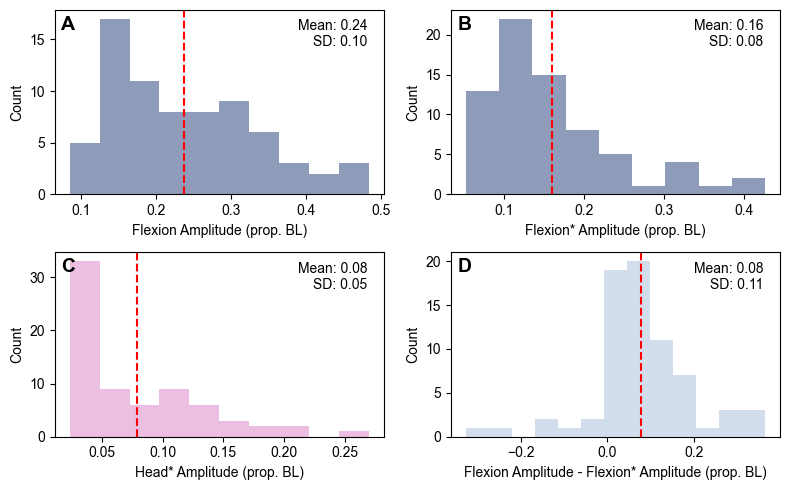

In [ ]:
plt.rcParams['font.family'] = 'Arial'  # Set font to Arial
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

# colors
col_tail, col_head, col_ratio = "#6A7BA2", "#E6A8D7", "#C5D3E6"

# add panel labels
labels = ['A', 'B', 'C', 'D']
for ax, label in zip(axes.flat, labels):
    ax.text(0.02, 0.97, label, transform=ax.transAxes,
            fontsize=14, fontweight='bold', ha='left', va='top')

# Top Left: instantaneous flexion amplitude (nd-dc)
sns.histplot(clean_cycles_sum['flex_amplitude_BL'], kde=False, ax=axes[0, 0], color=col_tail, edgecolor=None, binwidth=0.04)

flex_mean_sum = clean_cycles_sum['flex_amplitude_BL'].mean()
flex_std_sum = clean_cycles_sum['flex_amplitude_BL'].std()
axes[0, 0].axvline(flex_mean_sum, color='red', linestyle='dashed')

axes[0, 0].text(0.95, 0.95, f'Mean: {flex_mean_sum:.2f}\nSD: {flex_std_sum:.2f}', 
                transform=axes[0, 0].transAxes, ha='right', va='top', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
axes[0, 0].set_xlabel('TBA (prop. BL)')

# Top Right: relative flexion amplitude (nd(smoothed)-dc)
sns.histplot(clean_cycles_relative_sum['flex_amplitude_BL'], kde=False, ax=axes[0, 1], color=col_tail, edgecolor=None, binwidth=0.04)

flex_mean_relative = clean_cycles_relative_sum['flex_amplitude_BL'].mean()
flex_std_relative = clean_cycles_relative_sum['flex_amplitude_BL'].std()
axes[0, 1].axvline(flex_mean_relative, color='red', linestyle='dashed')

axes[0, 1].text(0.95, 0.95, f'Mean: {flex_mean_relative:.2f}\nSD: {flex_std_relative:.2f}', 
                transform=axes[0, 1].transAxes, ha='right', va='top', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
axes[0, 1].set_xlabel('TBA* (prop. BL)')


# Bottom Left: head amplitude (nd(smoothed)-nd)
sns.histplot(clean_cycles_relative_sum['head_amplitude_BL'], kde=False, ax=axes[1, 0], color=col_head, edgecolor=None, binwidth=0.025)

head_mean_relative = clean_cycles_relative_sum['head_amplitude_BL'].mean()
head_std_relative = clean_cycles_relative_sum['head_amplitude_BL'].std()
axes[1, 0].axvline(head_mean_relative, color='red', linestyle='dashed')

axes[1, 0].text(0.95, 0.95, f'Mean: {head_mean_relative:.2f}\nSD: {head_std_relative:.2f}', 
                transform=axes[1, 0].transAxes, ha='right', va='top', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
axes[1, 0].set_xlabel('HA* (prop. BL)')

# Bottom Right: instantaneous-relative flexion amplitude
difference = clean_cycles_sum['flex_amplitude_BL'] - clean_cycles_relative_sum['flex_amplitude_BL']
sns.histplot(difference, kde=False, ax=axes[1, 1], color=col_ratio, edgecolor=None, binwidth=0.055)

diff_mean = difference.mean()
diff_std = difference.std()
axes[1, 1].axvline(diff_mean, color='red', linestyle='dashed')

axes[1, 1].text(0.95, 0.95, f'Mean: {diff_mean:.2f}\nSD: {diff_std:.2f}', 
                transform=axes[1, 1].transAxes, ha='right', va='top', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
axes[1, 1].set_xlabel('TBA - TBA* (prop. BL)')

plt.tight_layout()

# Save the figure as a .jpg file
output_path = "I:/documents/DLCPaper/revisions/figures/FigureS1.jpg"  # Specify the path and file name
fig.savefig(output_path, format='jpg', dpi=300)  # Save the figure with 300 dpi resolution

plt.show()